# Traffic flow predicting

* Predicting traffic flow is of great importance to traffic management and public safety, and it has high requirements on accuracy and efficiency. In our paper, we propose an effective end-to-end model, called FedNet, to the predict traffic flow of each region in a city.

* In this notebook, we use [NYC Taxi Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) to generate the training data of [New-Flow and End-Flow](http://urban-computing.com/pdf/CrowFlowPrediction_SIGSPATIAL2016_Zheng-2.pdf) predicting task.

## Initialize

* Import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime
import matplotlib.pyplot as plt


pd.set_option('display.width', None)

* Define necessary constants.

In [2]:
latitude_min = 40.66
latitude_max = 40.82
longitude_min = -74.05
longitude_max = -73.89

year = 2014
path = 'data/taxi/yellow_tripdata_{}-{}.csv'

## Generate traffic flow

In [3]:
def make_grid(x, y, z):
    """Map traffic flow values to corresponding coordinates.

    Args:
        x: Latitudes.
        y: Longitudes.
        z: Traffic flow values.

    Returns:
        A 2D numpy array.
    """
    
    j = ((x - latitude_min) / 0.01).round(0).astype(int)
    k = ((y - longitude_min) / 0.01).round(0).astype(int)

    grid = np.zeros([16, 16])
    grid[j, k] = z
    return grid

In [4]:
def pickup(year, month):    
    """Read the csv file of correspond year and month and generate New-Flow.

    Args:
        year: int.
        month: int.

    Returns:
        A list of 2D numpy array.
    """
        
    start_datetime = datetime.datetime.strptime('{}-{}-01 00:00:00'.format(year, str(month).zfill(2)), "%Y-%m-%d %H:%M:%S")
    end_datetime = datetime.datetime.strptime('{}-{}-01 00:00:00'.format(year, str(month+1).zfill(2)), "%Y-%m-%d %H:%M:%S")
    
    df = pd.read_csv(path.format(year, str(month).zfill(2)), index_col=0)
    
    df = df[[' pickup_datetime', ' pickup_latitude', ' pickup_longitude', ]]
    
    df = df.round({' pickup_latitude': 2, 
                   ' pickup_longitude': 2, 
                  })
    
    df = df[
        (df[' pickup_latitude'] >= latitude_min) &
        (df[' pickup_latitude'] < latitude_max) &
        (df[' pickup_longitude'] >= longitude_min) &
        (df[' pickup_longitude'] < longitude_max)
        ]
    
    tmp = pd.DataFrame({' pickup_datetime': '{}-{}-01 00:00:00'.format(year, str(month).zfill(2)), 
                        ' pickup_latitude': np.NaN, 
                        ' pickup_longitude': np.NaN, 
                       }, index=['0'])

    tmp.index = pd.DatetimeIndex(tmp[" pickup_datetime"])

    df = tmp.append(df)
    
    df.index = pd.DatetimeIndex(df[" pickup_datetime"])
    
    df = df.sort_index()
    
    df = df[(df.index >= start_datetime) & (df.index < end_datetime)]
    
    groups = df.groupby(pd.Grouper(closed='left', freq='1H'))
    
    pickup_list = []
    
    for name, group in groups:
        df = pd.DataFrame(group)
        df = pd.DataFrame({'start': df.groupby([' pickup_latitude', ' pickup_longitude']).size()}).reset_index()
        df = df[[' pickup_latitude', ' pickup_longitude', 'start']]
        
        pickup_list.append(make_grid(df[' pickup_latitude'], df[' pickup_longitude'], df['start']))
        
    return pickup_list

In [5]:
def drop(year, month):    
    """Read the csv file of correspond year and month and generate End-Flow.

    Args:
        year: int.
        month: int.

    Returns:
        A list of 2D numpy array.
    """
        
    start_datetime = datetime.datetime.strptime('{}-{}-01 00:00:00'.format(year, str(month).zfill(2)), "%Y-%m-%d %H:%M:%S")
    end_datetime = datetime.datetime.strptime('{}-{}-01 00:00:00'.format(year, str(month+1).zfill(2)), "%Y-%m-%d %H:%M:%S")
    
    df = pd.read_csv(path.format(year, str(month).zfill(2)), index_col=0)
    
    df = df[[' dropoff_datetime', ' dropoff_latitude', ' dropoff_longitude', ]]
    
    df = df.round({' dropoff_latitude': 2, 
                   ' dropoff_longitude': 2, 
                  })
    
    df = df[
        (df[' dropoff_latitude'] >= latitude_min) &
        (df[' dropoff_latitude'] < latitude_max) &
        (df[' dropoff_longitude'] >= longitude_min) &
        (df[' dropoff_longitude'] < longitude_max)
        ]
    
    tmp = pd.DataFrame({' dropoff_datetime': '{}-{}-01 00:00:00'.format(year, str(month).zfill(2)), 
                        ' dropoff_latitude': np.NaN, 
                        ' dropoff_longitude': np.NaN, 
                       }, index=['0'])

    tmp.index = pd.DatetimeIndex(tmp[" dropoff_datetime"])

    df = tmp.append(df)
    
    df.index = pd.DatetimeIndex(df[" dropoff_datetime"])
    
    df = df.sort_index()
    
    df = df[(df.index >= start_datetime) & (df.index < end_datetime)]
    
    groups = df.groupby(pd.Grouper(closed='left', freq='1H'))
    
    drop_list = []
    for name, group in groups:
        df = pd.DataFrame(group)
        df = pd.DataFrame({'end': df.groupby([' dropoff_latitude', ' dropoff_longitude']).size()}).reset_index()
        df = df[[' dropoff_latitude', ' dropoff_longitude', 'end']]
        
        drop_list.append(make_grid(df[' dropoff_latitude'], df[' dropoff_longitude'], df['end']))
        
    return drop_list

In [6]:
pickup_list = []
drop_list = []

In [7]:
for i in range(4, 10):
    pickup_list += pickup(year, i)  

/home/xiaosen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
pickup_array = np.array(pickup_list)
pickup_array = np.expand_dims(pickup_array, axis=1)
pickup_array.shape

(4392, 1, 16, 16)

In [9]:
for i in range(4, 10):
    drop_list += drop(year, i)  

/home/xiaosen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [10]:
drop_array = np.array(drop_list)
drop_array = np.expand_dims(drop_array, axis=1)
drop_array.shape

(4392, 1, 16, 16)

In [11]:
pickup_and_drop = np.concatenate([pickup_array, drop_array], axis=1)
pickup_and_drop.shape

(4392, 2, 16, 16)

## Cache traffic flow

In [12]:
with open('data/taxi_1616.pkl', 'wb') as handle:
    pickle.dump(pickup_and_drop, handle)

In [13]:
pickup_and_drop_file = open("data/taxi_1616.pkl", 'rb')
pickup_and_drop = pickle.load(pickup_and_drop_file)
pickup_and_drop_file.close()

## Make external features

In [14]:
start_datetime = datetime.datetime.strptime('2014-04-01 00:00:00', "%Y-%m-%d %H:%M:%S")
end_datetime = datetime.datetime.strptime('2014-10-01 00:00:00', "%Y-%m-%d %H:%M:%S")

In [15]:
index = pd.date_range(start=start_datetime, freq='1H', end=end_datetime).tolist()
index.pop()
columns = ['quarter','month', 'day', 'weekday', 'hour', 'weekofyear', ]

In [16]:
external = pd.DataFrame(index=index, columns=columns)

In [17]:
external['quarter'] = external.index.quarter
external['month'] = external.index.month
external['day'] = external.index.day
external['weekday'] = external.index.weekday
external['hour'] = external.index.hour
external['weekofyear'] = external.index.weekofyear

external['is_month_start'] = external.index.is_month_start.astype(int)
external['weekend'] = (external['weekday'] // 5 == 1).astype(int)

In [18]:
external.reset_index(inplace=True, drop=True)

In [19]:
external.head()

,quarter,month,day,weekday,hour,weekofyear,is_month_start,weekend
0,2,4,1,1,0,14,1,0
1,2,4,1,1,1,14,1,0
2,2,4,1,1,2,14,1,0
3,2,4,1,1,3,14,1,0
4,2,4,1,1,4,14,1,0


## Normalization

In [20]:
class MinMaxNormalization(object):
    """MinMax Normalization --> [-1, 1]
       x = (x - min) / (max - min).
       x = x * 2 - 1
    """

    def __init__(self):
        pass

    def fit(self, X):
        self._min = X.min()
        self._max = X.max()

    def transform(self, X):
        X = 1. * (X - self._min) / (self._max - self._min)
        X = X * 2. - 1.
        return X

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        X = (X + 1.) / 2.
        X = 1. * X * (self._max - self._min) + self._min
        return X

In [21]:
min_max_scaler = MinMaxNormalization()
min_max_scaler.fit(pickup_and_drop[:-240].reshape(-1, 1))
scaled_pickup_and_drop = min_max_scaler.transform(pickup_and_drop.reshape(-1, 1)).reshape(-1, 2, 16, 16)

In [22]:
min_max = MinMaxNormalization()
external = min_max.fit_transform(external)
external = np.asarray(external)

## Unroll data

In [23]:
X = []
Y = []
External = []

In [24]:
unroll_length = 171
predict_length = 1

In [25]:
for i in range(unroll_length, 4392-predict_length+1):
    X.append([ scaled_pickup_and_drop[i-168], scaled_pickup_and_drop[i-24], scaled_pickup_and_drop[i-1] ])
    Y.append(scaled_pickup_and_drop[i])
    External.append(external[i])

In [26]:
X = np.asarray(X)
Y = np.asarray(Y)
External = np.asarray(External)

## Save data

In [27]:
with open('data/taxi_061616_X.pkl', 'wb') as handle:
    pickle.dump(X, handle)
    
with open('data/taxi_061616_Y.pkl', 'wb') as handle:
    pickle.dump(Y, handle)
    
with open('data/taxi_061616_External.pkl', 'wb') as handle:
    pickle.dump(External, handle)

## Visualization

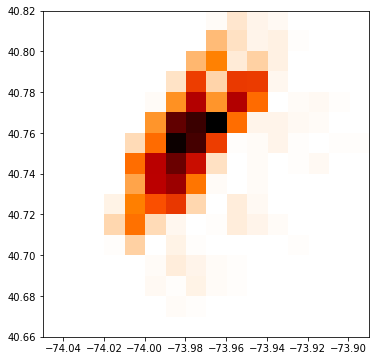

In [28]:
sum_tmp = pickup_and_drop.sum(axis=0)
plt.figure(figsize=(6, 6))
plt.imshow(sum_tmp[0], cmap='gist_heat_r', origin='lower',extent=(-74.05, -73.89, 40.66, 40.82), alpha=1)
plt.show()